<a href="https://colab.research.google.com/github/connor-keegan/Data-Science-1002/blob/main/Assignments/12_CAPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment was completed by Zach Atlas and Connor Keegan

## Capital Asset Pricing Model (CAPM)

### Assignment due Monday 22 April at noon

---

### Objectives

This assignment is primarily meant to refresh your numpy and pandas skills.  
Technical objectives are discussed below.  

- All the usual rules apply:  you may work together (groups of at most 3), make sure all names are easy to find at the top of the submission, submit the link to your working colab notebook


### Background

In finance, CAPM is a single-factor regression model used for analyzing (and predicting) excess stock returns. There are better, more accurate models, but it has its uses. For example, the *market beta* is a useful output which has something to do with the risk of particular investments.

1.  Read [this brief synopsis](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) of CAPM.


Don't worry if you don't understand all the terminology.
Look for a moment at the main formula (in the "Formula" section).  For us that formula will look like this:

\begin{aligned}
E(R_A) = R_f + \beta_A (E(R_{SP}) - R_f)
\end{aligned}

Some notes on the symbols in this formula:
- The formula is used to estimate $E(R_A)$.  The $E$ here stands for the expected value, and $R_A$ is the rate of return of the investment $A$.
- To use this formula, you therefore need to know the values of the other variables.
- The variable $R_f$ is the "risk-free rate," which is the amount of return you can get on an investment that has zero risk, like say a bank account.
This quantity changes over time but for our purposes we can treat it as a constant.  It is hard-coded into the code below.  Make sure you see where this variable occurs in the formula above.
- In this assignment the variable $R_{SP}$ is a measure of the rate of return of the overall market.  (The $E$ on the right side also means expected value.)
- The variable $\beta_A$ measures something about the relative risk of the investment A, relative to the overall market.  The technical objective of this assignment will be to compute $\beta_A$ below, and then to examine how sensitive it is to the specific data.
- The value you get for $\beta_A$ will be a number.  If it is greater than 1, it means (*very roughly*) that the investment A is more volatile than the overall market.  If it is less than 1, it means that the investment is less volatile than the overall market.  But **do not take this too seriously!** In particular see all the caveats at the wikipedia page.
- The A investment in our example is an individual stock (Apple).



2.  Load the packages and data.  (Note that the following code chunk also hard-codes the constant $R_f$.)  
The data lives in the file `capm_market_data` in the `data` folder on the `GitHub` site.

In [162]:
# load numpy and pandas packages
!pip install pandas
!pip install tabula-py
import tabula
import numpy as np
import pandas as pd

# get data
df = pd.DataFrame(tabula.read_pdf('/content/DS 1002 Capm data - Sheet1.pdf', pages ='all')[0])
# risk-free Treasury rate
R_f = 0.0175 / 252

3.  Look at some records.  
SPY is something that mirrors the S&P 500 ("the market").  
AAPL is the code for Apple stock.  
The values are closing prices, adjusted for splits and dividends.

In [163]:
df

,date,spy_adj_close,aapl_adj_close
0,2020-01-02,321.555786,298.829956
1,2020-01-03,319.120911,295.924713
2,2020-01-06,320.338379,298.282715
3,2020-01-07,319.437653,296.879883
4,2020-01-08,321.140106,301.655548
5,2020-01-09,323.317627,308.062988
6,2020-01-10,322.387207,308.759399
7,2020-01-13,324.604401,315.355865
8,2020-01-14,324.109497,311.097534
9,2020-01-15,324.841919,309.764313


4.  Drop the date column

In [164]:
data = df.copy()
del data["date"]
data

,spy_adj_close,aapl_adj_close
0,321.555786,298.829956
1,319.120911,295.924713
2,320.338379,298.282715
3,319.437653,296.879883
4,321.140106,301.655548
5,323.317627,308.062988
6,322.387207,308.759399
7,324.604401,315.355865
8,324.109497,311.097534
9,324.841919,309.764313


5.  Compute daily returns (percentage changes in price) for both SPY and AAPL.
(Be sure to drop the first row of NaN.)  
Hint: pandas has functions to easily do this.  
Print the first 5 rows of returns.


In [165]:
data["spy_daily_returns"] = data["spy_adj_close"].pct_change(periods=1)
data["aapl_daily_returns"] = data["aapl_adj_close"].pct_change(periods=1)
data = data.dropna()
data.head(5)

,spy_adj_close,aapl_adj_close,spy_daily_returns,aapl_daily_returns
1,319.120911,295.924713,-0.007572,-0.009722
2,320.338379,298.282715,0.003815,0.007968
3,319.437653,296.879883,-0.002812,-0.004703
4,321.140106,301.655548,0.005330,0.016086
5,323.317627,308.062988,0.006781,0.021241


6.  Save the SPY and AAPL returns into separate numpy arrays.  
Print the first five values from each of the two arrays.


In [167]:
spy_daily_returns_array = np.array(data["spy_daily_returns"])
aapl_daily_returns_array = np.array(data["aapl_daily_returns"])
print(f"The first five values of the SPY returns array are: \n {spy_daily_returns_array[:5]}")
print(f"The first five values of the AAPL returns array are: \n {aapl_daily_returns_array[:5]}")

The first five values of the SPY returns array are: 
 [-0.00757217  0.00381507 -0.0028118   0.00532953  0.00678059]
The first five values of the AAPL returns array are: 
 [-0.00972206  0.00796825 -0.00470303  0.01608619  0.02124092]


7.  Make arrays (one for SPY, one for AAPL) containing the *excess* returns by subtracting the constant $R_f$ from the returns.  
(Recall that $R_f$ is the "risk-free rate" meaning essentially that you could earn this much in interest if you didn't invest in anything.)  
Print the LAST five excess returns from both SPY and AAPL numpy arrays.

In [168]:
spy_excess_array = (spy_daily_returns_array - R_f)
aapl_excess_array = (aapl_daily_returns_array - R_f)
print(f"The last five excess returns from the SPY numpy array are: \n {spy_excess_array[-5:]}")
print(f"The last five excess returns from the AAPL numpy array are: \n {aapl_excess_array[-5:]}")

The last five excess returns from the SPY numpy array are: 
 [ 0.00739588  0.0016636   0.00637333 -0.00113644  0.00153272]
The last five excess returns from the AAPL numpy array are: 
 [ 0.00468012 -0.00610279  0.02367838 -0.00719053  0.00017687]


8. Make a scatterplot with SPY excess returns on the $x$-axis and AAPL excess returns on the $y$-axis.  
If you need it, here is the [Matplotlib documentation]( https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).

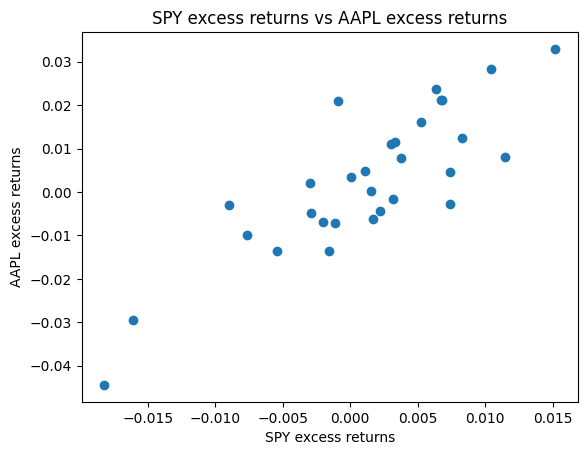

In [169]:
import matplotlib.pyplot as plt
x = spy_excess_array
y = aapl_excess_array
plt.scatter(x,y)
plt.title("SPY excess returns vs AAPL excess returns")
plt.xlabel("SPY excess returns")
plt.ylabel("AAPL excess returns")
plt.show()

The value of $\beta_A$ is computed from the arrays you built in problem 7, via a formula that uses some statistical functions called the "variance" and the "covariance."

Any individual 1-d array of numbers has a variance, which you can compute using `numpy`'s function `var()` (documented [here](https://numpy.org/doc/stable/reference/generated/numpy.var.html)).  This is a number.

If you have two 1-d arrays of the same length, they collectively have something called a covariance which `numpy` also can compute using `cov()` (documented [here](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)).

The covariance is also a number, but look at what happens when you send two 1-d arrays to `cov()`: it returns a $2\times 2$ matrix.  (Try it!)  The covariance we are looking for is the number that lives in both the top right and the bottom left of this matrix.  (Those two numbers should be the same.)  The top left and bottom right entries of the covariance matrix also have meaning, but we don't need them.



9. Use `numpy` functions as described above to compute the estimate of $\beta_A$, using the following formula:  
\begin{aligned} \beta_A= \frac{ \text{cov}(A,SP) }{ \text{var}(SP) } \end{aligned}
In our context, A will be the 1-d array you made in problem 7 for AAPL, and SP will be the 1-d array you made for SPY.

In [170]:
A = aapl_excess_array
SP = spy_excess_array
covariance = np.cov(A, SP)
Ba_numerator = covariance[1,0]
Ba_denominator = np.var(SP)
Ba = (Ba_numerator / Ba_denominator)
print(f"An estimate of Ba is: {Ba}")

An estimate of Ba is: 1.935703176191532


You should have found that the beta estimate is greater than one.  
This means that the volatility of AAPL stock, given the data, and according to this particular (flawed) model,
is higher than the volatility of the S&P 500.

Bonus:  Is this something you can see on the plot you made?



Yes, from our plot we can see that Ba will be greater than one due to how variance and covarience are calculated. First, we know Ba will be positive because there is a positive relationship between the SPY excess values and the AAPL excess values. Secondly, we can see that Ba will be greater than one because the coviarience will be greater than the varience. We know the covarience will be greater because the Y values (AAPL excess values) are more spread out than the X values (SPY excess values). This is demonstarted by the scale of the Y values being 0.07 in length, whereas the scale of the X values is 0.03 in length; also, we see that the data points do not vary too far from the hypothetical linear regression line, so this difference in scales is not due to just a few unusual Y values. Variance is calculated by squaring the difference between each individual data point and the mean for a single data set (and dividing by the number of data points), whereas covarience is calculated by multiplying the difference of each X value and the mean of X by the difference of each corresponding Y value and the mean of Y (and dividing by the number of data points). Because varience multiplies the difference between each point in a data set and the mean of the data set by itself, while covarience multiplies the difference between each value in the same data set and the mean of that data set by the difference between each value in another data set and the mean of that data set, when determining whether covarience or varience will be larger, you can cancel out the first factor in each numerator as well as the sample size in the denominator, since we use the same data set in varience and  covarience in this example. This means that covarience/varience in this example is equal to the sum of all differences between each point and the mean in the Y data set divided by the sum of all differences between each point and the mean in the X data set. Since the Y data points are more spread out, the sum of the differences between the Y data points and the mean of Y will be greater than the sum of the differences between the X data points and the mean of X, so the covarience will be larger than the varience, and covarience/varience will be greater than one.

Finally, let's look at how sensitive the beta is to each data point.   
We want to drop each data point (one at a time), compute \\(\hat\beta_i\\) using our formula from above, and save each measurement.

This is called *jackknifing*.



10. Write a function called `beta_sensitivity()` with these specs:

- take numpy arrays `x` and `y` as inputs
- outputs a list of tuples, so that each tuple contains (observation row dropped, beta estimate)

Hint: **np.delete(x, i).reshape(-1,1)** will delete observation i from array x, and make it a column vector

In [171]:
def beta_sensitivity(A,SP):
  tuple_list = []
  for i in range(len(A)):
    A_new = np.delete(A,i)
    SP_new = np.delete(SP,i)
    covariance = np.cov(A_new,SP_new)
    numerator = covariance[1,0]
    denominator = np.var(SP_new)
    Ba = (numerator / denominator)
    output = [i,Ba]
    output_tuple = tuple(output)
    tuple_list.append(output_tuple)
  return tuple_list

11. Call `beta_sensitivity()` on the arrays A and SP from earlier and print the first ten tuples of output.

In [158]:
A = aapl_excess_array
SP = spy_excess_array
beta_sensitivity_output = beta_sensitivity(A,SP)
print(beta_sensitivity_output[:10])

[(0, 1.9634104867537836), (1, 1.9372676185319966), (2, 1.938476521877673), (3, 1.9224455647189982), (4, 1.9075284116340168), (5, 1.9585658565824784), (6, 1.9071865160136943), (7, 1.9169650204060706), (8, 1.9436773471742623), (9, 1.9546191393702896)]
